In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility


def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)



# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learing_rate = 0.01
iterations = 500
LSTM_stack = 1


# Choose stock
stock = "KRX:005380"
pred_label = 3 # 0 : Open, 1: High 2: Low, 3:Close 4:Volumne

# data scrolling parts
from pandas_datareader import data, wb
from datetime import datetime

# 날짜 지정
now=datetime.now()
year = now.year
month = now.month
day = now.day

start = datetime(2010, 1, 2)
end = datetime(year, month, day)
df = data.DataReader(
    stock,  # name
    "google",  # data source
    start,  # start
    end  # end
)



In [2]:
# Convert pandas dataframe to numpy array
dataset_temp = df.as_matrix()
#dataset_temp = dataset_temp[:-1,:]



In [3]:
# Open, High, Low, Volume, Close
test_min = np.min(dataset_temp, 0)
test_max = np.max(dataset_temp, 0)
test_denom = test_max - test_min

dataset = MinMaxScaler(dataset_temp)


In [4]:

dataset_temp = df.as_matrix()
test_last_X = (dataset_temp[-seq_length:,:]-test_min)/(test_denom+1e-7);

#test_last_min = np.min(test_last_X, 0)
#test_last_max = np.max(test_last_X, 0)
#test_last_denom = test_last_max - test_last_min




In [5]:
# build a dataset
dataX = []
dataY = []
dataY_temp = []
for i in range(0, len(dataset) - seq_length):
    _x = dataset[i:i + seq_length]
    #_y = dataset_label[i + seq_length]  # Next close price
    _y = dataset[i + seq_length]
    dataX.append(_x)
    dataY.append(_y)
    

# train/test split 70 / 30
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])


In [6]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim], name='input_X')
Y = tf.placeholder(tf.float32, [None, 1], name='intput_Y')

# build a LSTM network
def lstm_cell():
    cell_temp = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    return cell_temp

cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(LSTM_stack)], state_is_tuple=True)


outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y), name='losses_sum')  # sum of the squares

# optimizer
optimizer = tf.train.AdamOptimizer(learing_rate)
train = optimizer.minimize(loss, name='train')

# RMSE
targets = tf.placeholder(tf.float32, [None, 1], name='targets')
predictions = tf.placeholder(tf.float32, [None, 1], name='predictions')
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)), name='rmse')

In [7]:
outputs.shape

TensorShape([Dimension(None), Dimension(7), Dimension(10)])

In [8]:
Y_pred.shape

TensorShape([Dimension(None), Dimension(1)])

In [9]:
 outputs[:, -1]

<tf.Tensor 'strided_slice_1:0' shape=(?, 10) dtype=float32>

In [10]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Tensorboard
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./tensorflowlog", sess.graph)

    losslist = [];
    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY[:, [pred_label]]})
        losslist = np.append(losslist, step_loss)

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse = sess.run(rmse, feed_dict={
        targets: testY[:, [pred_label]], predictions: test_predict})
    print("RMSE: {}".format(rmse))

    # Predictions test
    prediction_test = sess.run(Y_pred, feed_dict={X: test_last_X.reshape(1, 7, 5)})
   

RMSE: 0.021420985460281372


In [11]:
print("predictions ", end='')
print(prediction_test *test_denom[pred_label]+test_min[pred_label])

predictions [[ 151996.4375]]


In [12]:
# Plot losss
plt.figure(1)
plt.plot(losslist, color="green", label="Error");
plt.xlabel("Iteration Number")
plt.ylabel("Sum of the Squarred Error")
plt.legend(loc='upper right', frameon=False)



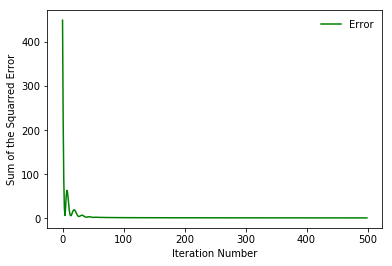

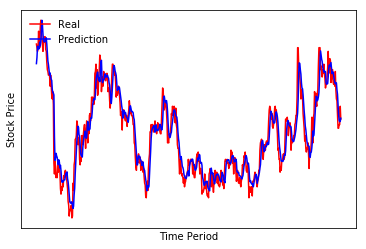

In [13]:
# Plot predictions
plt.figure(2)
testY_plt=testY[:, [pred_label]]*test_denom[pred_label]+test_min[pred_label]
test_predict_plt=test_predict*test_denom[pred_label]+test_min[pred_label]
plt.plot(testY_plt, color="red", label="Real")
plt.plot(test_predict_plt, color="blue", label="Prediction")
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend(loc='upper left', frameon=False)
plt.xticks([])
plt.yticks([])

plt.show()

In [14]:
(testY_plt-test_predict_plt).max()



17861.812499958964

In [15]:
Total_size=df.as_matrix().shape[0]
Total_size

1866

In [16]:
Predict_size=test_predict_plt.shape[0]
Predict_size

558

In [17]:
Predict_close_concat=np.concatenate((np.zeros((Total_size-Predict_size,1)) ,test_predict_plt), axis=0)
df["Predict Close"]=Predict_close_concat.round()
df

,Open,High,Low,Close,Volume,Predict Close
Date,,,,,,
2010-01-04,119500.0,120500.0,118000.0,119000.0,1380805,0.0
2010-01-05,118000.0,119000.0,110000.0,110000.0,2991217,0.0
2010-01-06,111000.0,112500.0,108000.0,111000.0,1669419,0.0
2010-01-07,111000.0,111500.0,105000.0,106000.0,1725316,0.0
2010-01-08,106000.0,107000.0,102500.0,106000.0,2162295,0.0
2010-01-11,107500.0,107500.0,101500.0,101500.0,1833273,0.0
2010-01-12,102000.0,104000.0,101500.0,103000.0,1468097,0.0
2010-01-13,102000.0,103500.0,101500.0,102000.0,1221166,0.0
2010-01-14,103000.0,104500.0,102500.0,103500.0,1176712,0.0


In [18]:
Total_size

1866